# **Proyek II : Membuat Model Machine Learning dengan Data Time Series - Dicoding x Kampus Merdeka**

# **DATA DIRI**

* Nama      : Karlina Surya Witanto
* ID        : M014V6051
* PT        : Universitas Udayana
* Email     : gabriella.linatan@gmail.com
* Email SIB : m014v6051@dicoding.org

# **1. Import Library & Import Dataset**

Sumber Dataset : https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata?select=openweatherdata-denpasar-1990-2020v0.1.csv

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Import Dataset dari Google Drive dan tampilkan dalam dataframe**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/openweatherdata-denpasar-1990-2020v0.1.csv')
df.head(11)

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1/1/1990 0:00,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,1/1/1990 1:00,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,1/1/1990 2:00,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,1/1/1990 3:00,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,1/1/1990 4:00,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d
5,1/1/1990 5:00,28800,Denpasar,-8.652497,115.219117,27.23,27.23,27.23,1009.0,82,1.67,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,803,Clouds,broken clouds,04d
6,1/1/1990 6:00,28800,Denpasar,-8.652497,115.219117,27.32,27.32,27.32,1008.0,82,2.17,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,803,Clouds,broken clouds,04d
7,1/1/1990 7:00,28800,Denpasar,-8.652497,115.219117,27.29,27.29,27.29,1008.0,82,2.91,219,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,500,Rain,light rain,10d
8,1/1/1990 8:00,28800,Denpasar,-8.652497,115.219117,27.34,27.34,27.34,1007.0,81,2.40,230,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,500,Rain,light rain,10d
9,1/1/1990 9:00,28800,Denpasar,-8.652497,115.219117,27.23,27.23,27.23,1007.0,82,1.91,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,804,Clouds,overcast clouds,04d


# **2. Visualisasi Data - Grafik**

In [4]:
# Total data

df.shape

(264924, 29)

In [5]:
#menghitung jumlah data yang terbaru

df.weather_main.value_counts()

Clouds          220657
Rain             34901
Thunderstorm      4724
Clear             3941
Haze               548
Mist                74
Smoke               29
Fog                 16
Dust                10
Tornado              8
Drizzle              8
Squall               4
Ash                  4
Name: weather_main, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


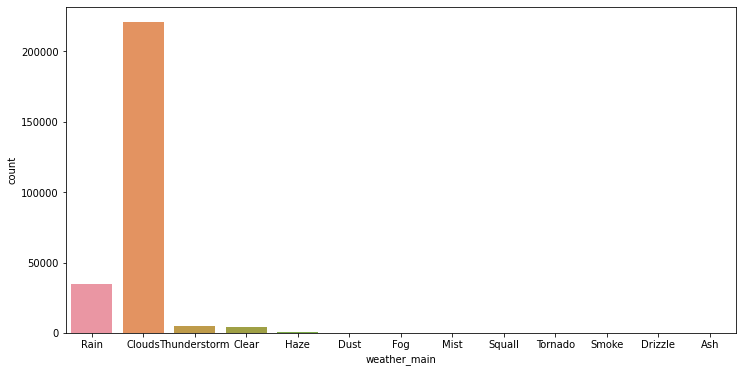

In [6]:
plt.figure(figsize = (12, 6))
sns.countplot(df.weather_main)

# **3. Mengecek Kolom yang Mengandung Variabel Kosong**

In [7]:
df.isnull().sum()


dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
temp_min                    0
temp_max                    0
pressure                    0
humidity                    0
wind_speed                  0
wind_deg                    0
rain_1h                248638
rain_3h                248768
rain_6h                228826
rain_12h               264912
rain_24h               258107
rain_today             264924
snow_1h                264924
snow_3h                264924
snow_6h                264924
snow_12h               264924
snow_24h               264924
snow_today             264924
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

# **4. Drop Kolom yang Mengandung Variabel Kosong**

In [8]:
df=df.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
df.head()

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1/1/1990 0:00,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,86,1.36,225,98,500,Rain,light rain,10d
1,1/1/1990 1:00,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,84,2.09,247,91,500,Rain,light rain,10d
2,1/1/1990 2:00,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,84,2.44,262,94,500,Rain,light rain,10d
3,1/1/1990 3:00,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,82,2.29,271,94,500,Rain,light rain,10d
4,1/1/1990 4:00,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,82,1.71,274,76,803,Clouds,broken clouds,04d


# **5. Drop Kolom yang Tidak Digunakan**

In [9]:
df.drop(columns=['lat', 'lon', 'timezone','weather_icon', 'city_name'],
                 inplace=True, axis=1)

# **6. Mengambil 15.000 Data**

In [10]:
df_train = df[1:12001]
df_val = df[12002:15002]


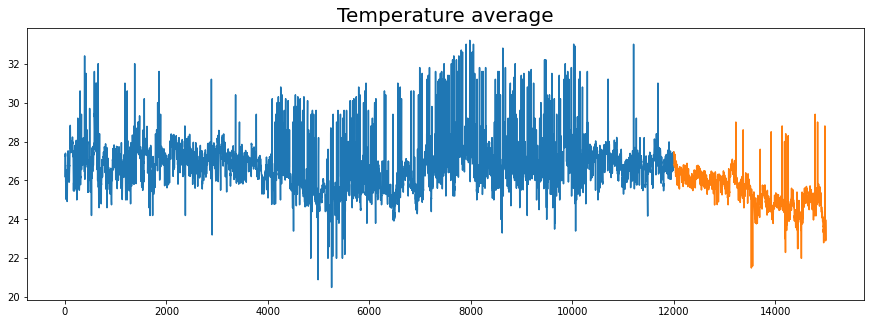

In [11]:

plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train['temp'])
plt.title('Temperature average',
          fontsize=20);
plt.plot(df_val.index, df_val['temp'])
plt.title('Temperature average',
          fontsize=20);


In [12]:
T_date = df_train['dt_iso']
T_temp  = df_train['temp'].values

V_date = df_val['dt_iso'].values
V_temp = df_val['temp'].values


In [13]:
T_temp_r=T_temp.reshape(-1, 1)
V_temp_r=V_temp.reshape(-1, 1)


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
scaler = MinMaxScaler()
T_temp_r_s = scaler.fit_transform(T_temp_r)
V_temp_r_s = scaler.fit_transform(V_temp_r)

# **7. LSTM Model**

In [16]:
data_x_train = windowed_dataset(T_temp_r_s, window_size=60, batch_size=65, shuffle_buffer=1000)
data_x_test = windowed_dataset(V_temp_r_s, window_size=60, batch_size=65, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True), 
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
    
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



**Eksekusi Model LSTM**

In [17]:
history = model.fit(data_x_train ,epochs=65, validation_data=data_x_test, callbacks=[lr_schedule])

Epoch 1/65
184/184 [==============================] - 48s 230ms/step - loss: 1.9014 - mae: 2.3967 - val_loss: 1.8606 - val_mae: 2.3552
Epoch 2/65
184/184 [==============================] - 39s 213ms/step - loss: 1.8811 - mae: 2.3763 - val_loss: 1.8387 - val_mae: 2.3332
Epoch 3/65
184/184 [==============================] - 39s 214ms/step - loss: 1.8578 - mae: 2.3529 - val_loss: 1.8143 - val_mae: 2.3086
Epoch 4/65
184/184 [==============================] - 40s 215ms/step - loss: 1.8320 - mae: 2.3269 - val_loss: 1.7873 - val_mae: 2.2815
Epoch 5/65
184/184 [==============================] - 40s 216ms/step - loss: 1.8038 - mae: 2.2985 - val_loss: 1.7582 - val_mae: 2.2523
Epoch 6/65
184/184 [==============================] - 40s 215ms/step - loss: 1.7729 - mae: 2.2676 - val_loss: 1.7259 - val_mae: 2.2198
Epoch 7/65
184/184 [==============================] - 40s 215ms/step - loss: 1.7380 - mae: 2.2324 - val_loss: 1.6887 - val_mae: 2.1823
Epoch 8/65
184/184 [==============================] - 4

# **8. Membuat plot MAE dan loss**

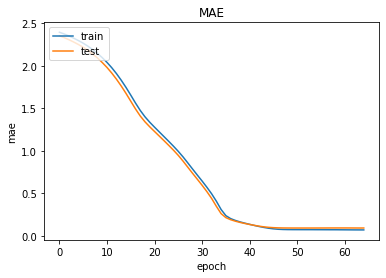

In [18]:
import matplotlib.pyplot as plt

# plot of mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

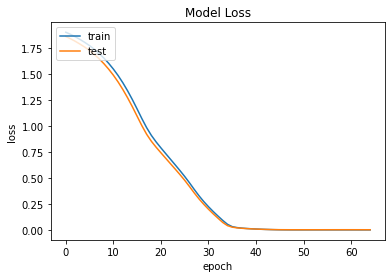

In [19]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()